In [1]:
import glob
import os
import pandas as pd
from io import StringIO
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')
import numpy as np
import matplotlib as mpl
import sys
mpl.rcParams.update(mpl.rcParamsDefault)

plt.rc('font', family='sans-serif')#, serif='Times')
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=11)
#plt.rcParams['mathtext.fontset'] = 'stix'
#plt.rcParams['font.family'] = 'STIXGeneral'
params = {
'text.usetex': True,
#'font.size': 15,
#'text.latex.unicode': True
}
plt.rcParams.update(params)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Query full indexes

In [103]:
graphs = [
    '/cluster/work/grlab/projects/metagenome/data/metasub/graphs/k19/graph_merged_k19.primary.dbg',
    '/cluster/work/grlab/projects/metagenome/data/BIGSI/graph_primary.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/metagut_graphs/graph_merged_complete_k31.primary.dbg',
    '/cluster/work/grlab/projects/metagenome/data/uhgg/uhgg_catalogue/graphs/graph_complete_k31.dbg',
    '/cluster/work/grlab/projects/metagenome/data/uhgg/all_genomes/graph_complete_k31.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/fungi_graphs/fungi_all_cleanable_no_pacbio_no_nanopore_primary.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/viridiplantae_graphs/graph_primary.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/mus_musculus/metazoa_mus_musculus_primary.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/metazoa_graphs/metazoa_all_files.shuf.head10000.primary.dbg',
    '/cluster/work/grlab/projects/metagenome/data/tcga/graph_merged_complete_k31.primary.dbg',
    '/cluster/work/grlab/projects/metagenome/data/gtex/graphs/output_k41_trimmed_clean_graph/graph_merged_k41.primary.dbg',
    '/cluster/work/grlab/projects/metagenome/data/gtex/graphs/output_k41_trimmed_clean_graph_extended/graph_merged_k41.primary.dbg',
    '/cluster/work/grlab/projects/metagenome/data/gnomad/release_3.0_graphs/graph_gnomad_complete_k41.dbg',
    '/cluster/work/grlab/projects/metagenome/data/kingsford/kingsford_primary.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/graph_merged_complete_k31.primary.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/graph_merged_complete_k31.primary.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/graph_merged_complete_k31.primary.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/graph_merged_complete_k31.primary.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/graph_merged_complete_k31.primary.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/graph_merged_complete_k31.primary.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/graph_merged_complete_k31.primary.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/graph_merged_complete_k31.primary.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/graph_merged_complete_k31.primary.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/graph_merged_complete_k31.primary.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/graph_merged_complete_k31.primary.dbg',
    '/cluster/work/grlab/projects/metagenome/data/refseq/release97/output_k31_annotation/k31_taxid/graph.dbg',
    '/cluster/work/grlab/projects/metagenome/data/refseq/release97/output_k31_annotation/k31_full/graph.dbg'
]
graphs_small = [
    '/cluster/work/grlab/projects/metagenome/data/metasub/graphs/k19/graph_merged_k19.primary.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/BIGSI/graph_primary.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/metagut_graphs/graph_primary.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/uhgg/uhgg_catalogue/graphs/graph_complete_k31.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/uhgg/all_genomes/graph_complete_k31.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/fungi_graphs/graph_primary.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/viridiplantae_graphs/graph_primary.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/mus_musculus/metazoa_mus_musculus_primary.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/metazoa_graphs/metazoa_all_files.shuf.head10000.primary.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/tcga/graph_merged_complete_k31.primary.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/gtex/graphs/output_k41_trimmed_clean_graph/graph_merged_k41.primary.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/gtex/graphs/output_k41_trimmed_clean_graph_extended/graph_merged_k41.primary.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/gnomad/release_3.0_graphs/graph_gnomad_complete_k41.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/kingsford/kingsford_primary.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/graph_merged_complete_k31.primary.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/graph_merged_complete_k31.primary.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/graph_merged_complete_k31.primary.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/graph_merged_complete_k31.primary.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/graph_merged_complete_k31.primary.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/graph_merged_complete_k31.primary.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/graph_merged_complete_k31.primary.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/graph_merged_complete_k31.primary.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/graph_merged_complete_k31.primary.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/graph_merged_complete_k31.primary.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/graph_merged_complete_k31.primary.small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/refseq/release97/output_k31_annotation/k31_taxid/graph_small.dbg',
    '/cluster/work/grlab/projects/metagenome/data/refseq/release97/output_k31_annotation/k31_full/graph_small.dbg',
]
annos = [
    '/cluster/work/grlab/projects/metagenome/data/metasub/graphs/k19/annotation.relaxed.relabeled.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/BIGSI/annotation/annotation_primary_renamed.relaxed.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/metagut_graphs/annotation_cluster_original.relaxed.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/uhgg/uhgg_catalogue/graphs/annotation.relaxed.relabeled.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/uhgg/all_genomes/annotation.relaxed.relabeled.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/fungi_graphs/annotation.relaxed.relabeled.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/viridiplantae_annotation/annotation.relaxed.relabeled.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/mus_musculus/nobackup/build/annotation.relaxed.relabeled.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/metazoa_graphs/nobackup/build_10k/annotation.relaxed.relabeled.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/tcga/graph_merged_complete_k31_annotation_per_sample.primary.rd.relaxed.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/gtex/graphs/output_k41_trimmed_clean_annotation_per_sample.primary.relabeled.relaxed.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/gtex/graphs/output_k41_trimmed_clean_extended_annotation_per_sample.primary.relax.relabeled.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/gnomad/release_3.0_annotation/gnomad.genomes.r3.0.sites.all.k41.relax.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/kingsford/annotation/annotation_primary.rb_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/annotation_0.relaxed.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/annotation_1.relaxed.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/annotation_2.relaxed.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/annotation_3.relaxed.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/annotation_4.relaxed.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/annotation_5.relaxed.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/annotation_6.relaxed.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/annotation_7.relaxed.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/annotation_8.relaxed.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/annotation_9.relaxed.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/cloudcompute/homo_sapiens_graphs/annotation_10.relaxed.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/refseq/release97/output_k31_annotation/k31_taxid/annotation.relaxed.relabeled.row_diff_brwt.annodbg',
    '/cluster/work/grlab/projects/metagenome/data/refseq/release97/output_k31_annotation/k31_full/annotation.relaxed_64.row_diff_brwt.annodbg',
]
queries = [
    '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/samples/haib18CEM5453_HMCMJCCXY_SL336225.fasta',
    '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/samples/nucleotide_fasta_protein_homolog_model.fasta',
    '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/samples/DRR067889.fasta',
    '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/samples/SRR322873.fastq.gz',
    '/cluster/work/grlab/projects/metagenome/data/alignment/completeness/wgs_samples/all/query_time/realignment_reads.fa'
]

In [102]:
for query in queries:
    for graph, anno in zip(graphs_small, annos):
        print(graph)
        !~/projects/projects2014-metagenome/metagraph/scripts/run_query.sh $graph $anno $query

/cluster/work/grlab/projects/metagenome/data/cloudcompute/mus_musculus/metazoa_mus_musculus_primary.small.dbg
graph:		/cluster/work/grlab/projects/metagenome/data/cloudcompute/mus_musculus/metazoa_mus_musculus_primary.small.dbg
annotation:	/cluster/work/grlab/projects/metagenome/data/cloudcompute/mus_musculus/nobackup/build/annotation.relaxed.relabeled.row_diff_brwt.annodbg
query:		/cluster/work/grlab/projects/metagenome/data/alignment/completeness/wgs_samples/all/query_time/realignment_reads.fa

Logs will be written to /cluster/work/grlab/projects/metagenome/data/cloudcompute/mus_musculus/metazoa_mus_musculus_primary.small.dbg.benchmarks/annotation.relaxed.relabeled.row_diff_brwt.annodbg_realignment_reads.fa.*
Generic job.
Job <2095113> is submitted to queue <normal.24h>.


In [57]:
!ls -lh /cluster/work/grlab/projects/metagenome/data/uhgg/all_genomes/graph_complete_k31.dbg.benchmarks/

total 900K
-rw-rw---- 1 mikhaika INFK-Raetsch-All  49K May  3 18:36 SRR322873.fastq.gz.err
-rw-rw---- 1 mikhaika INFK-Raetsch-All 2.3K May  3 18:36 SRR322873.fastq.gz.lsf
-rw-rw---- 1 mikhaika INFK-Raetsch-All 842K May  3 18:36 SRR322873.fastq.gz.out


In [104]:
import numpy as np
import re
from Bio import SeqIO

def parse_time_from_log(log_file):
    try:
        lines_time = !grep "total time:" $log_file
        for line_time in lines_time:
            return float(re.search('total time: ([0-9\.]*)', line_time).group(1))
    except:
        pass
    return np.nan

prefix='/cluster/work/grlab/projects/metagenome/data/'

def parse_seqs(records):
    seq_len = []
    for record in records:
        length = len(record.seq)
        if length:
            seq_len.append(length)
    return seq_len

for query in queries:
    if query.endswith('fastq.gz'):
        import gzip
        with gzip.open(query, "rt") as f:
            seq_len = parse_seqs(SeqIO.parse(f, 'fastq'))
    else:
        with open(query, 'r') as f:
            seq_len = parse_seqs(SeqIO.parse(f, 'fasta'))
    print(f'Query: {query}')
    print(f'Num sequences: {len(seq_len)}')
    print(f'Avg length: {np.mean(seq_len)}')

    print("      Time", "    ms/read", "\treads/sec", "\tIndex")
    for graph, anno in zip(graphs_small, annos):
        graph = !readlink -f $graph
        graph = graph[0]
        anno_str = !readlink -f $anno
        anno_str = anno_str[0]
        T = parse_time_from_log(f"{graph}.benchmarks/{anno_str.split('/')[-1]}_{query.split('/')[-1]}.err")
        if graph.startswith(prefix):
            graph = graph[len(prefix):]
        print("{:6.1f} sec".format(T),
              "\t{:6.1f}".format(T / len(seq_len) * 1e3),
              "\t{:9.1f}".format(len(seq_len) / T),
              f"\t{graph}")
    print()

Query: /cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/samples/haib18CEM5453_HMCMJCCXY_SL336225.fasta
Num sequences: 23200
Avg length: 151.0
      Time     ms/read 	reads/sec 	Index
1633.0 sec 	  70.4 	     14.2 	metasub/graphs/k19/graph_merged_k19.primary.small.dbg
 948.3 sec 	  40.9 	     24.5 	BIGSI/graph_primary.small.dbg
   nan sec 	   nan 	      nan 	cloudcompute/metagut_graphs/graph_primary.small.dbg
  58.9 sec 	   2.5 	    393.7 	uhgg/uhgg_catalogue/graphs/graph_complete_k31.small.dbg
 122.9 sec 	   5.3 	    188.8 	uhgg/all_genomes/graph_complete_k31.small.dbg
 345.5 sec 	  14.9 	     67.1 	cloudcompute/fungi_graphs/graph_primary.small.dbg
   nan sec 	   nan 	      nan 	cloudcompute/viridiplantae_graphs/graph_primary.small.dbg
 224.1 sec 	   9.7 	    103.5 	cloudcompute/mus_musculus/metazoa_mus_musculus_primary.small.dbg
 190.3 sec 	   8.2 	    121.9 	cloudcompute/metazoa_graphs/metazoa_all_files.shuf.head10000.primary.small.dbg
  76.3 sec 	   3.3 	    303.9 	t

  24.5 sec 	   1.6 	    609.1 	refseq/release97/output_k31_annotation/graph_k31_small.dbg
4240.7 sec 	 284.5 	      3.5 	refseq/release97/output_k31_annotation/graph_k31_small.dbg

Query: /cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/samples/SRR322873.fastq.gz
Num sequences: 2094
Avg length: 419.5391595033429
      Time     ms/read 	reads/sec 	Index
  18.1 sec 	   8.6 	    115.7 	metasub/graphs/k19/graph_merged_k19.primary.small.dbg
 115.5 sec 	  55.1 	     18.1 	BIGSI/graph_primary.small.dbg
   nan sec 	   nan 	      nan 	cloudcompute/metagut_graphs/graph_primary.small.dbg
   1.5 sec 	   0.7 	   1412.6 	uhgg/uhgg_catalogue/graphs/graph_complete_k31.small.dbg
   5.5 sec 	   2.6 	    379.7 	uhgg/all_genomes/graph_complete_k31.small.dbg
   8.2 sec 	   3.9 	    254.2 	cloudcompute/fungi_graphs/graph_primary.small.dbg
   nan sec 	   nan 	      nan 	cloudcompute/viridiplantae_graphs/graph_primary.small.dbg
   6.2 sec 	   3.0 	    338.3 	cloudcompute/mus_musculus/metazoa_m

In [32]:
import numpy as np
import re
from Bio import SeqIO

def parse_time_from_log(log_file):
    try:
        lines_time = !grep "total time:" $log_file
        for line_time in lines_time:
            return float(re.search('total time: ([0-9\.]*)', line_time).group(1))
    except:
        pass
    return np.nan

prefix='/cluster/work/grlab/projects/metagenome/data/'

for query in queries:
    seq_len = []
    with open(query, 'r') as f:
        for record in SeqIO.parse(f, 'fasta'):
            length = len(record.seq)
            if length:
                seq_len.append(length)
    print(f'Query: {query}')
    print(f'Num sequences: {len(seq_len)}')
    print(f'Avg length: {np.mean(seq_len)}')

    print("      Time", "    ms/read", "\treads/sec", "\tIndex")
    for graph in graphs_small:
        graph_str = graph
        if graph_str.startswith(prefix):
            graph_str = graph_str[len(prefix):]
        T = parse_time_from_log(f"{graph}.benchmarks/{query.split('/')[-1]}.err")
        print("{:6.1f} sec".format(T),
              "\t{:6.1f}".format(T / len(seq_len) * 1e3),
              "\t{:9.1f}".format(len(seq_len) / T),
              f"\t{graph_str}")
    print()

Query: /cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/samples/haib18CEM5453_HMCMJCCXY_SL336225.fasta
Num sequences: 23200
Avg length: 151.0
      Time     ms/read 	reads/sec 	Index
 558.5 sec 	  24.1 	     41.5 	metasub/graphs/k19/graph_merged_k19.primary.small.dbg
 602.1 sec 	  26.0 	     38.5 	BIGSI/graph_primary.small.dbg
  61.3 sec 	   2.6 	    378.6 	uhgg/uhgg_catalogue/graphs/graph_complete_k31.small.dbg
  96.2 sec 	   4.1 	    241.2 	uhgg/all_genomes/graph_complete_k31.small.dbg
 187.7 sec 	   8.1 	    123.6 	cloudcompute/fungi_graphs/graph_primary.small.dbg
  56.8 sec 	   2.4 	    408.7 	tcga/graph_merged_complete_k31.primary.small.dbg
  47.4 sec 	   2.0 	    489.0 	gtex/graphs/output_k41_trimmed_clean_graph/graph_merged_k41.primary.small.dbg
  74.3 sec 	   3.2 	    312.4 	gtex/graphs/output_k41_trimmed_clean_graph_extended/graph_merged_k41.primary.small.dbg
  65.6 sec 	   2.8 	    353.6 	gnomad/release_3.0_graphs/graph_gnomad_complete_k41.small.dbg
4313.4 sec

In [2]:
!pip install -U "git+https://github.com/ratschlab/metagraph.git#subdirectory=metagraph/api/python"

  Cloning https://github.com/ratschlab/metagraph.git to /tmp/pip-req-build-_syvtjah
  Running command git clone -q https://github.com/ratschlab/metagraph.git /tmp/pip-req-build-_syvtjah
  Running command git submodule update --init --recursive -q
  Created wheel for metagraph: filename=metagraph-0.1.0-py2.py3-none-any.whl size=4777 sha256=9cca520e5543ee206c0d296888495927872a500eddbd381d70f42c53e47fac23
  Stored in directory: /tmp/pip-ephem-wheel-cache-rjfnafju/wheels/27/ed/5b/2c2b0f237081777c973dcee6af6721d22c373ee1d9877b66ba
Successfully built metagraph


In [12]:
from metagraph.client import GraphClient
mtg = GraphClient('metagraph.ethz.ch', 8080, api_path='/api/bigsi')

In [84]:
query_fasta = !cat ~/metagenome/data/BIGSI/subsets/query/samples/haib18CEM5453_HMCMJCCXY_SL336225.fasta
query_fasta = '\n'.join(query_fasta)

In [5]:
with open('/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/query/samples/haib18CEM5453_HMCMJCCXY_SL336225.fasta') as f:
    query_fasta = f.read()

In [13]:
%%time

mtg.search(query_fasta, top_labels=5, discovery_threshold=0.0)

RuntimeError: Error while calling the server API 200 <Response [200]>

In [79]:
len(query_fasta.split('>')[1].split('\n')[1])

151

In [80]:
23200 * 151

3503200

9750

In [87]:
23200 / 21

1104.7619047619048

full, row-diff

In [96]:
23200 / 670.01

34.626348860464766

rowdiff-brwt

In [100]:
23200 / 787.86

29.44685604041327

### Fungi

In [2]:
from metagraph.client import GraphClient
mtg = GraphClient('dnaloc.ethz.ch', 80, api_path='/api/fungi')

In [3]:
%%time
mtg.search(query_fasta, top_labels=1, discovery_threshold=0.0)

NameError: name 'query_fasta' is not defined

In [93]:
23200 / 170

136.47058823529412

## Scalability (subgraphs)

### Load data

In [2]:
DIR = '/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/'

graph_primary_size = []
graph_primary_small_size = []
annotation_size_rbfish_primary = []
annotation_size_brwt_primary = []
annotation_size_brwt_primary_relaxed = []
annotation_size_rb_brwt_primary = []
annotation_size_rd_brwt_primary = []
annotation_size_rd_sparse_primary = []

for i in range(750, 24751, 750):
    graph_primary_size.append(os.path.getsize(DIR + 'graph_subset_{}_primary.dbg'.format(i)))
    graph_primary_small_size.append(os.path.getsize(DIR + 'graph_subset_{}_primary.small.dbg'.format(i)))
    try:
        annotation_size_rbfish_primary.append(os.path.getsize(DIR + 'annotation/annotation_subset_{}_primary.rbfish.annodbg'.format(i)))
    except:
        annotation_size_rbfish_primary.append(np.nan)
    try:
        annotation_size_brwt_primary_relaxed.append(os.path.getsize(DIR + 'annotation/annotation_subset_{}_primary.relaxed.brwt.annodbg'.format(i)))
    except:
        annotation_size_brwt_primary_relaxed.append(np.nan)
    try:
        annotation_size_rb_brwt_primary.append(os.path.getsize(DIR + 'annotation/annotation_subset_{}_primary.rb_brwt.annodbg'.format(i)))
    except:
        annotation_size_rb_brwt_primary.append(np.nan)
    try:
        annotation_size_rd_brwt_primary.append(os.path.getsize(DIR + 'annotation/annotation_subset_{}_primary.relaxed.row_diff_brwt.annodbg'.format(i)))
    except:
        annotation_size_rd_brwt_primary.append(np.nan)
    try:
        annotation_size_rd_sparse_primary.append(os.path.getsize(DIR + 'annotation/annotation_subset_{}_primary.row_diff_sparse.annodbg'.format(i)))
    except:
        annotation_size_rd_sparse_primary.append(np.nan)

results = pd.DataFrame(columns=['n_samples', 'graph_primary', 'graph_primary_small',
                                'anno_rbfish_primary',
                                'anno_brwt_primary_relaxed',
                                'anno_rb_brwt_primary',
                                'anno_rd_sparse_primary',
                                'anno_rd_brwt_primary'],
                       data=zip(list(range(750, 24751, 750)),
                                graph_primary_size,
                                graph_primary_small_size,
                                annotation_size_rbfish_primary,
                                annotation_size_brwt_primary_relaxed,
                                annotation_size_rb_brwt_primary,
                                annotation_size_rd_sparse_primary,
                                annotation_size_rd_brwt_primary))
results.shape[0]

33

In [3]:
results

,n_samples,graph_primary,graph_primary_small,anno_rbfish_primary,anno_brwt_primary_relaxed,anno_rb_brwt_primary,anno_rd_sparse_primary,anno_rd_brwt_primary
0,750,365273397,186917531,911050410,1200620989,811155176,159337288,93385373
1,1500,584008411,293856388,1795523586,2206167605,1432212464,335362356,173193146
2,2250,775600027,389308100,2812655504,3221995011,2021616423,531370359,259231049
3,3000,951690661,474380674,3904728513,4135085473,2580141049,729305927,336907993
4,3750,1088471572,542024979,5202347458,4849655177,3051298608,948095557,410863624
5,4500,1278806702,639420250,6710896987,5874215756,3661845953,1177567642,514175824
6,5250,1462866336,730863689,8192829214,6796278639,4271317484,1427604140,608876474
7,6000,1597784679,798646992,9291797242,7504780540,4736490333,1671618785,698301523
8,6750,1728942675,863335834,11264320987,8265430875,5209788282,1909728937,770790879
9,7500,1911388019,953448456,12713221949,9217387114,5815815946,2171340312,865467871


In [4]:
bigsi_size = []

for i in range(750, 24751, 750):
    try:
        bigsi_size.append(os.path.getsize(DIR + 'bigsi/subsets/index_{}/combined-index'.format(i)))
    except:
        bigsi_size.append(np.nan)

results['bigsi_db'] = bigsi_size

In [5]:
DIR

'/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/'

In [6]:
bifrost_size = []

for i in range(750, 24751, 750):
    try:
        bifrost_size.append(os.path.getsize(f'{DIR}bifrost/v2/bigsi_bifrost_{i}.gfa')
                           + os.path.getsize(f'{DIR}bifrost/v2/bigsi_bifrost_{i}.bfg_colors'))
    except:
        bifrost_size.append(np.nan)

results['Bifrost'] = bifrost_size

In [7]:
for (h, fpr) in [#(1, 30),
                 #(1, 10), (3, 10),
                 #(1, 5), (2, 5), (3, 5), (4, 5),
                 #(1, 1), (2, 1), (3, 1), (4, 1), (5, 1),
                 (3, 10), (4, 5), (7, 1)]:
    cobs_size = []

    for i in range(750, 24751, 750):
        try:
            cobs_size.append(os.path.getsize(DIR + 'cobs/cobs_index_h{}_fpr{}_{}.cobs_compact'.format(h, fpr, i)))
        except:
            cobs_size.append(np.nan)

    results['cobs_h{}_fpr{}'.format(h, fpr)] = cobs_size

In [8]:
mantis_size = []
mantis_rrr_size = []
mantis_mst_size = []

for i in range(750, 24751, 750):
    try:
        mantis_size.append(os.path.getsize(DIR + 'mantis/cqfs/files_{}/dbg_cqf.ser'.format(i)))

        files = !find {DIR}mantis/cqfs/files_{i}/ -name *eqclass_rrr.cls
        if len(files):
            mantis_rrr_size.append(sum([os.path.getsize(f) for f in files]))
        else:
            mantis_rrr_size.append(np.nan)

        files = !find {DIR}mantis/cqfs/files_{i}/ -name *.bv
        if len(files) == 3:
            mantis_mst_size.append(sum([os.path.getsize(f) for f in files]))
        else:
            mantis_mst_size.append(np.nan)
    except:
        mantis_size.append(np.nan)
        mantis_rrr_size.append(np.nan)
        mantis_mst_size.append(np.nan)

results['mantis_index'] = mantis_size
results['mantis_rrr'] = mantis_rrr_size
results['mantis_mst'] = mantis_mst_size

### Scalability plots

#### All (supplement)

In [9]:
(results.graph_primary_small + results.anno_rd_brwt_primary).values

array([ 280302904,  467049534,  648539149,  811288667,  952888603,
       1153596074, 1339740163, 1496948515, 1634126713, 1818916327,
       1945249108, 2080294996, 2222031475, 2375432033, 2607120115,
       2708918982, 2857198608, 2999133586, 3183870905, 3302447814,
       3430030332, 3574258785, 3711345854, 3857697148, 3986648121,
       4102259998, 4228636829, 4367575809, 4511765083, 4599688915,
       4738652503, 4834449648, 4939693259])

In [10]:
(results / (results.graph_primary_small + results.anno_rd_brwt_primary).values.reshape(-1, 1)).max(0)

n_samples                     0.000005
graph_primary                 1.303138
graph_primary_small           0.666841
anno_rbfish_primary          11.325055
anno_brwt_primary_relaxed     5.203625
anno_rb_brwt_primary          3.270786
anno_rd_sparse_primary        1.806762
anno_rd_brwt_primary          0.543932
bigsi_db                     38.683389
Bifrost                      18.045039
cobs_h3_fpr10                      NaN
cobs_h4_fpr5                 16.237798
cobs_h7_fpr1                 24.934982
mantis_index                 36.933149
mantis_rrr                    6.394298
mantis_mst                    9.036213
dtype: float64

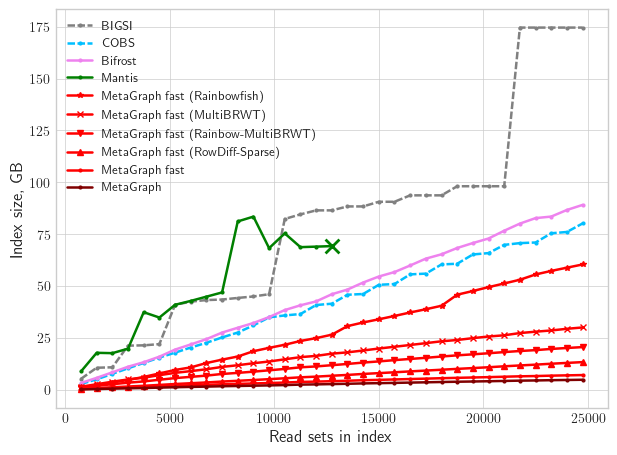

In [98]:
width = 3.487 * 1.5 * 1.2
height = width / 1.618 * 1.2

plt.rc('font', family='sans-serif')#, serif='Times')
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=10)
#plt.rcParams['mathtext.fontset'] = 'stix'
#plt.rcParams['font.family'] = 'STIXGeneral'
params = {
'text.usetex': True,
#'font.size': 15,
#'text.latex.unicode': True
}
plt.rcParams.update(params)

import matplotlib

with matplotlib.style.context('seaborn-whitegrid'):
    fig, axes = plt.subplots(1, 1, figsize=(width, height))
    #ax.set_title('RefSeq assembly graph')

    # results.sort_values('num_kmers', inplace=True)

    # colors = ['c', 'b', 'g', 'r']

    ax = axes

    lw = 1.8
    ms = 4
    # lines = ax.plot(results.n_samples,
    #                 results.mantis_index / 10**9,
    #                 marker='o', ms=ms, label='Mantis (CQF only)', linestyle=':', color='g')

    # ax.plot(results.n_samples,
    #         (results.mantis_index + results.mantis_rrr) / 10**9,
    #         marker='o', ms=ms, label='Mantis', color=lines[0].get_color())

    ax.plot(results.n_samples, results.bigsi_db / 10**9,
            marker='.', ms=ms, linewidth=lw, label='BIGSI', color='grey', linestyle=(0, (3, 1)))

#     h, fpr = (3, 10)
#     ax.plot(results.n_samples, results['cobs_h{}_fpr{}'.format(h, fpr)] / 10**9,
#             marker='o', ms=ms, linewidth=lw, label='COBS (FPR={}, h={})'.format(fpr / 100, h), color='royalblue', linestyle='-.')
#     h, fpr = (7, 1)
#     ax.plot(results.n_samples, results['cobs_h{}_fpr{}'.format(h, fpr)] / 10**9,
#             marker='.', ms=ms, linewidth=lw, label=f'COBS {fpr}\%', color='royalblue', linestyle=(0, (3, 1)))
    h, fpr = (4, 5)
    ax.plot(results.n_samples, results['cobs_h{}_fpr{}'.format(h, fpr)] / 10**9,
            marker='.', ms=ms, linewidth=lw, label=f'COBS', color='deepskyblue', linestyle=(0, (3, 1)))

    ax.plot(results.n_samples, results.Bifrost / 10**9,
            marker='.', ms=ms, linewidth=lw, label='Bifrost', color='violet')

    ax.plot(results.n_samples,
            (results.mantis_index + results.mantis_mst) / 10**9,
            marker='.', ms=ms, linewidth=lw, label='Mantis', color='g')
    plt.scatter(x=[results.n_samples[16],], y=[(results.mantis_index + results.mantis_mst).iloc[16] / 10**9],
                marker='x', s=100, color='g', linewidth=2)

    ax.plot(results.n_samples,
           (results.graph_primary + results.anno_rbfish_primary) / 10**9,
           marker='*', ms=ms, linewidth=lw, label='MetaGraph fast (Rainbowfish)', color='red')

    ax.plot(results.n_samples,
            (results.graph_primary + results.anno_brwt_primary_relaxed) / 10**9,
            marker='x', ms=ms, linewidth=lw, label='MetaGraph fast (MultiBRWT)', color='red')

    ax.plot(results.n_samples,
            (results.graph_primary + results.anno_rb_brwt_primary) / 10**9,
            marker='v', ms=ms, linewidth=lw, label='MetaGraph fast (Rainbow-MultiBRWT)', color='red')

    ax.plot(results.n_samples,
           (results.graph_primary + results.anno_rd_sparse_primary) / 10**9,
           marker='^', ms=ms, linewidth=lw, label='MetaGraph fast (RowDiff-Sparse)', color='red')

    ax.plot(results.n_samples,
        (results.graph_primary + results.anno_rd_brwt_primary) / 10**9,
        marker='.', ms=ms, linewidth=lw, label='MetaGraph fast', color='red')

    ax.plot(results.n_samples,
        (results.graph_primary_small + results.anno_rd_brwt_primary) / 10**9,
        marker='.', ms=ms, linewidth=lw, label='MetaGraph', color='maroon')

    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    #ax.tick_params(reset=True, direction='out', which='both', bottom=True, top=False, left=True, right=False, width=0.5)
    ax.grid(True, linewidth=0.5)
    legend = ax.legend(loc="best", fontsize=9, frameon=False)

#    ax.set_title('Bacterial data (BIGSI dataset)')
    ax.set_xlabel('Read sets in index')
    ax.set_ylabel('Index size, GB')
#    ax.set_xlim([-100, 250000])
    #ax.set_xticks(np.array(k_array))
    #ax.legend(loc='best')

    #legend.get_frame().set_facecolor('none')
    #ax.set_yscale('log')
    # plt.ylim([-5, 110])
    #plt.xlim([0, 50000])
    # axes[1].set_ylim([-1e-1, 75])
    # plt.yscale('symlog')

    plt.tight_layout()
    plt.savefig('graph_scalability_supp.pdf', format='pdf', bbox_inches='tight')
    plt.show()

#### Manuscript

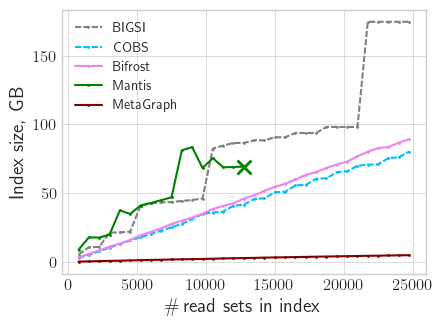

In [15]:
width = 3.487 * 1.3
height = width / 1.618 * 1.2

plt.rc('font', family='sans-serif')#, serif='Times')
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=14)
plt.rc('legend', fontsize=10)
#plt.rcParams['mathtext.fontset'] = 'stix'
#plt.rcParams['font.family'] = 'STIXGeneral'
params = {
'text.usetex': True,
#'font.size': 15,
#'text.latex.unicode': True
}
plt.rcParams.update(params)

import matplotlib

with matplotlib.style.context('seaborn-whitegrid'):
    fig, axes = plt.subplots(1, 1, figsize=(width, height))
    #ax.set_title('RefSeq assembly graph')

    # results.sort_values('num_kmers', inplace=True)

    # colors = ['c', 'b', 'g', 'r']

    ax = axes

    lw = 1.5
    ms = 2
    # lines = ax.plot(results.n_samples,
    #                 results.mantis_index / 10**9,
    #                 marker='o', ms=ms, label='Mantis (CQF only)', linestyle=':', color='g')

    # ax.plot(results.n_samples,
    #         (results.mantis_index + results.mantis_rrr) / 10**9,
    #         marker='o', ms=ms, label='Mantis', color=lines[0].get_color())

    ax.plot(results.n_samples, results.bigsi_db / 10**9,
            marker='.', ms=ms, linewidth=lw, label='BIGSI', color='grey', linestyle=(0, (3, 1)))

    h, fpr = (4, 5)
    ax.plot(results.n_samples, results['cobs_h{}_fpr{}'.format(h, fpr)] / 10**9,
            marker='.', ms=ms, linewidth=lw, label=f'COBS', color='deepskyblue', linestyle=(0, (3, 1)))

    ax.plot(results.n_samples, results.Bifrost / 10**9,
            marker='.', ms=ms, linewidth=lw, label='Bifrost', color='violet')

    ax.plot(results.n_samples,
            (results.mantis_index + results.mantis_mst) / 10**9,
            marker='.', ms=ms, linewidth=lw, label='Mantis', color='g')
    plt.scatter(x=[results.n_samples[16],], y=[(results.mantis_index + results.mantis_mst).iloc[16] / 10**9],
                marker='x', s=100, color='g', linewidth=2)

#     ax.plot(results.n_samples,
#         (results.graph_primary + results.anno_rd_brwt_primary) / 10**9,
#         marker='o', ms=ms, linewidth=lw, label='MetaGraph', color='red') #, alpha=0.5)

    ax.plot(results.n_samples,
        (results.graph_primary_small + results.anno_rd_brwt_primary) / 10**9,
        marker='.', ms=ms, linewidth=lw, label='MetaGraph', color='maroon')

    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    #ax.tick_params(reset=True, direction='out', which='both', bottom=True, top=False, left=True, right=False, width=0.5)
    ax.grid(True, linewidth=0.5)
    legend = ax.legend(loc="best", fontsize=10, frameon=False)

#    ax.set_title('Bacterial data (BIGSI dataset)')
    ax.set_xlabel('\#\,read sets in index')
    ax.set_ylabel('Index size, GB')
#    ax.set_xlim([-100, 250000])
    #ax.set_xticks(np.array(k_array))
    #     ax.legend(loc='best')

    #legend.get_frame().set_facecolor('none')
    #ax.set_yscale('log')
    # plt.ylim([-5, 110])
    #plt.xlim([0, 50000])
    # axes[1].set_ylim([-1e-1, 75])
    # plt.yscale('symlog')

    plt.tight_layout()
    plt.savefig('graph_scalability.pdf', format='pdf', bbox_inches='tight')
    plt.show()

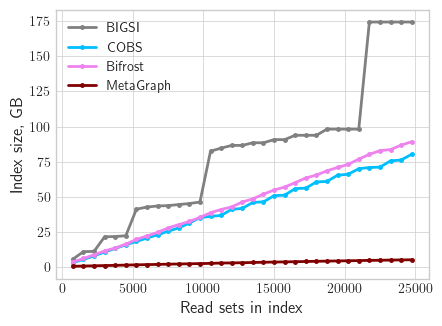

In [42]:
width = 3.487 * 1.3
height = width / 1.618 * 1.2

plt.rc('font', family='sans-serif')
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=10)
params = {'text.usetex': True,}
plt.rcParams.update(params)

import matplotlib

with matplotlib.style.context('seaborn-whitegrid'):
    fig, axes = plt.subplots(1, 1, figsize=(width, height))
    ax = axes

    lw = 2
    ms = 5

    ax.plot(results.n_samples, results.bigsi_db / 10**9,
            marker='.', ms=ms, linewidth=lw, label='BIGSI', color='grey')#, linestyle=(0, (3, 1)))

    h, fpr = (4, 5)
    ax.plot(results.n_samples, results['cobs_h{}_fpr{}'.format(h, fpr)] / 10**9,
            marker='.', ms=ms, linewidth=lw, label=f'COBS', color='deepskyblue')#, linestyle=(0, (3, 1)))

    ax.plot(results.n_samples, results.Bifrost / 10**9,
            marker='.', ms=ms, linewidth=lw, label='Bifrost', color='violet')

    ax.plot(results.n_samples,
        (results.graph_primary_small + results.anno_rd_brwt_primary) / 10**9,
        marker='.', ms=ms, linewidth=lw, label='MetaGraph', color='maroon')

    ax.grid(True, linewidth=0.5)
    legend = ax.legend(loc="best", fontsize=10, frameon=False)

    ax.set_xlabel('Read sets in index')
    ax.set_ylabel('Index size, GB')

    plt.tight_layout()
    plt.savefig('graph_scalability.pdf', format='pdf', bbox_inches='tight')
    plt.show()

In [77]:
results.bigsi_db / (results.graph_primary_small + results.anno_rd_brwt_primary)

0     19.222915
1     22.961828
2     16.865129
3     26.336643
4     22.572587
5     19.160596
6     30.616323
7     28.426736
8     26.509051
9     23.950538
10    22.793509
11    21.655631
12    20.761500
13    34.679882
14    32.440396
15    31.934671
16    30.277357
17    29.477038
18    27.766567
19    27.448756
20    26.427765
21    26.226529
22    25.257792
23    24.299566
24    24.614216
25    23.920526
26    23.205630
27    22.467380
28    38.683389
29    37.943949
30    36.831222
31    36.101392
32    35.332224
dtype: float64

In [78]:
results['cobs_h{}_fpr{}'.format(4, 5)] / (results.graph_primary_small + results.anno_rd_brwt_primary)

0     10.379701
1     11.014503
2     12.004473
3     12.878740
4     13.694792
5     13.545693
6     13.423476
7     13.663962
8     13.916878
9     13.917062
10    14.228234
11    14.956039
12    15.747286
13    15.120798
14    14.033806
15    15.108412
16    14.546879
17    15.294200
18    14.523018
19    15.340175
20    14.878224
21    15.580325
22    15.100903
23    15.676301
24    15.252973
25    15.911372
26    15.590336
27    16.002347
28    15.680102
29    15.443498
30    15.927333
31    15.742145
32    16.237798
dtype: float64

### Query time

In [43]:
# plt.rc('font', family='serif')#, serif='Times')
# plt.rc('xtick', labelsize=10)
# plt.rc('ytick', labelsize=10)
# plt.rc('axes', labelsize=12)
# plt.rc('legend', fontsize=10)
# #plt.rcParams['mathtext.fontset'] = 'stix'
# #plt.rcParams['font.family'] = 'STIXGeneral'
# params = {
# 'text.usetex': False,
# #'font.size': 15,
# #'text.latex.unicode': True
# }
# plt.rcParams.update(params)

def parse_time_from_logs(log_files):
    table = []
    for log_file in log_files:
        try:
            if log_file.split('/')[-2].endswith('align_labeled_indexed'):
                lines_time = !grep "total time" $log_file
                for line_time in lines_time:
                    query_time = float(re.search('total time ([0-9\.]*)', line_time).group(1))
                    table.append({'n_samples': int(log_file.split('/')[-1].split('.')[-2]),
                                  'total_time': query_time})
                continue
            elif log_file.split('/')[-2].startswith('metagraph'):
                lines_time = !grep "total time:" $log_file
                for line_time in lines_time:
                    query_time = float(re.search('total time: ([0-9\.]*)', line_time).group(1))
                    table.append({'n_samples': int(log_file.split('/')[-1].split('.')[-2]),
                                  'total_time': query_time})
                continue

            if log_file.split('/')[-2].startswith('bifrost'):
                lines_time = !grep "Time for all queries: " $log_file
                for line_time in lines_time:
                    query_time = float(re.search('Time for all queries: ([0-9\.]*) milliseconds', line_time).group(1)) / 1e3
                    table.append({'n_samples': int(log_file.split('/')[-1].split('.')[-2]),
                                  'total_time': query_time})
                continue

            if log_file.split('/')[-2].startswith('mantis'):
                lines_time = !grep "Time =" $log_file
                for line_time in lines_time:
                    try:
                        query_time = float(re.search('Time = ([0-9\.]*) s', line_time).group(1))
                        table.append({'n_samples': int(log_file.split('/')[-1].split('.')[-2]),
                                      'total_time': query_time})
                    except:
                        query_time = float(re.search('Time = ([0-9\.]*) ms', line_time).group(1)) / 1000
                        table.append({'n_samples': int(log_file.split('/')[-1].split('.')[-2]),
                                      'total_time': query_time})                        
                continue

            lines_user = !grep "User time (seconds):" $log_file
            lines_system = !grep "System time (seconds):" $log_file
            assert(len(lines_user) == len(lines_system))
            for line_user, line_system in zip(lines_user, lines_system):
                query_time = float(re.search('User time \(seconds\): ([0-9\.]*)', line_user).group(1))
                #query_time += float(re.search('System time \(seconds\): ([0-9\.]*)', line_system).group(1))
                table.append({'n_samples': int(log_file.split('/')[-1].split('.')[-2]),
                              'total_time': query_time})
        except:
            pass

    table = pd.DataFrame.from_records(table)
    return table

#### All (supplement)

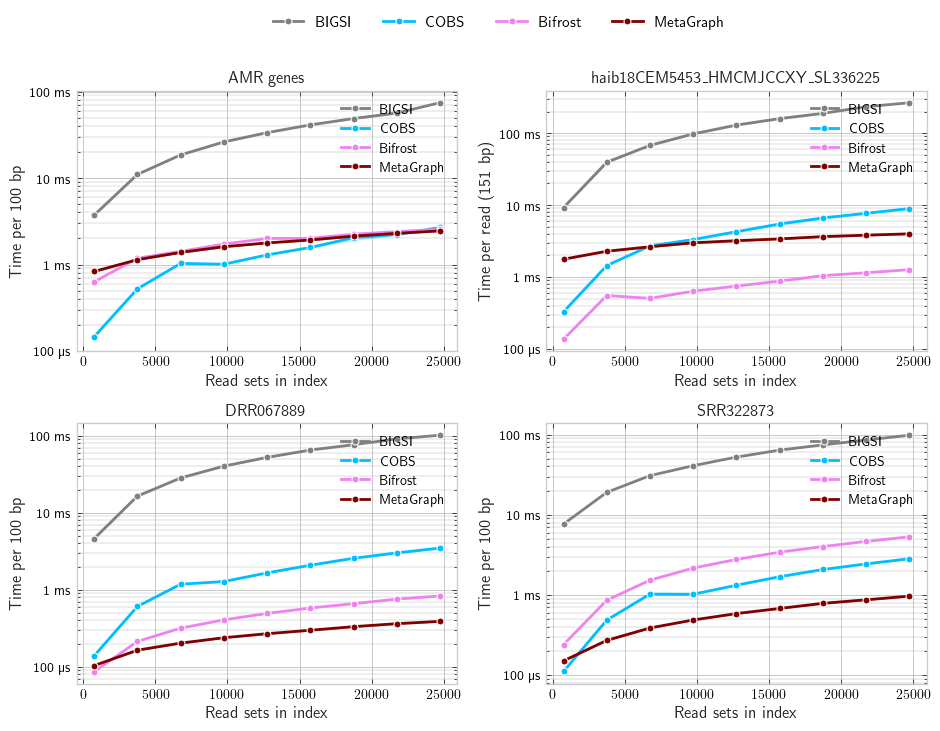

In [80]:
import re
import seaborn as sns

colors = {'BIGSI': 'grey',
          'Mantis': 'g',
          'Bifrost': 'violet',
          'COBS 1\%': 'royalblue',
          'COBS': 'deepskyblue',
          'MetaGraph-Align': 'black',
          'MetaGraph-LA': 'goldenrod',
          'MetaGraph-align-sparse-indexed': 'maroon',
          'MetaGraph': 'maroon',
          'MetaGraph (row-major), small': 'maroon'}

markers = {'COBS 1\%': 'o',
           'COBS': 'o',
           'MetaGraph (Rainbowfish)': '*',
           'MetaGraph (MultiBRWT)': 'x',
           'MetaGraph (Rainbow-BRWT)': '<',
           'MetaGraph': 'o',
           'MetaGraph OLD': 'x',
           'MetaGraph (row-major)': '^',
           'MetaGraph (row-major), small': '^',
           'MetaGraph small': 'o',
           'MetaGraph-align OLD': 'x',
#            'MetaGraph-Align': '*',
#            'MetaGraph-LA': '*',
           }

width = 3.487 * 1.3 * 2.1
height = width / 1.4 #/ 1.618

with matplotlib.style.context('seaborn-whitegrid'):
    fig, axes = plt.subplots(2, 2, figsize=(width, height))

def plot_query_time(i, j, DIR, OTHER, title=None, normalizer=1, y_label='Query time, sec'):
    ax = axes[i, j]

    results = {}
    results['BIGSI'] = parse_time_from_logs(glob.glob(OTHER + '/bigsi/*.err'))
#    results['COBS 1\%'] = parse_time_from_logs(glob.glob(OTHER + '/cobs_index_h7_fpr1/*.err'))
    results['COBS'] = parse_time_from_logs(glob.glob(OTHER + '/cobs_index_h4_fpr5/*.err'))
    results['Bifrost'] = parse_time_from_logs(glob.glob(OTHER + '/bifrost/*.err'))
#    results['Mantis'] = parse_time_from_logs(glob.glob(OTHER + '/mantis.mst/*.out'))
#    results['Mantis'].loc[results['Mantis']['n_samples'] > 14000] = np.nan
#    results['MetaGraph (Rainbowfish)'] = parse_time_from_logs(glob.glob(DIR + '/release_metagraph.primary.rbfish/*.err'))
#    results['MetaGraph (MultiBRWT)'] = parse_time_from_logs(glob.glob(DIR + '/release_metagraph.primary.brwt_relaxed/*.err'))
#    results['MetaGraph (Rainbow-BRWT)'] = parse_time_from_logs(glob.glob(DIR + '/release_metagraph.primary.rb_brwt/*.err'))
#    results['MetaGraph (row-major)'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.rd_sparse/*.err'))
    results['MetaGraph'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.small.rd_brwt/*.err'))
#    results['MetaGraph fast'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.rd_brwt/*.err'))
#    results['MetaGraph fast Sparse'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.rd_sparse/*.err'))
#    results['MetaGraph OLD'] = parse_time_from_logs(glob.glob(DIR + '/release_metagraph.primary.rd_brwt/*.err'))
#    results['MetaGraph (RowDiff-MultiBRWT), no batch'] = parse_time_from_logs(glob.glob(DIR + '/release_metagraph.primary.rd_brwt.nobatch/*.err'))
#    results['MetaGraph-align OLD'] = parse_time_from_logs(glob.glob(DIR + '/release_metagraph.primary.rd_brwt.align/*.err'))
#    results['MetaGraph-align small'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.small.rd_brwt.align/*.err'))
#    results['MetaGraph-align'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.rd_brwt.align/*.err'))
#    results['MetaGraph-align-sparse'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.rd_sparse.align/*.err'))
#    results['MetaGraph-Align'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.rd_brwt.align_indexed/*.err'))
#    results['MetaGraph-LA'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.rd_brwt.align_labeled_indexed/*.err'))
#    results['Metagraph (no batch)'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.rb_brwt.notbatch/*.err'))

    # colors = ['c', 'b', 'g', 'r']

    for name, table in results.items():
        table.sort_values('n_samples', inplace=True)
#         x = table['n_samples']
#         y = table['total_time']
        table['total_time'] /= normalizer
#        x = results.index[~results[col].isna()]
#        y = results[col][~results[col].isna()]
        color = colors[name] if name in colors.keys() else 'red'
        m = markers[name] if name in markers.keys() else 'o'
        alpha = 1 #0.5 if name.startswith('MetaGraph (R') else 1
        sns.lineplot(ax=ax, x='n_samples', y='total_time', data=table, marker=m, ms=5, linewidth=2, label=name, color=color, alpha=alpha)
#         if name.startswith('BIGSI') or name.startswith('COBS'):
#             ax.lines[-1].set_linestyle(':')
        if name.endswith('no batch'):
            ax.lines[-1].set_linestyle('-.')
#        ax.plot(x, y, marker='o', ms=3, linewidth=2.5, label=name)

#     n_s = results['Mantis']['n_samples'].max()
#     ax.scatter(x=[n_s,], y=[results['Mantis']['total_time'][results['Mantis']['n_samples'] == n_s].mean()],
#                 marker='x', s=100, color='g', linewidth=2)

    if not title:
        title = DIR.split('.')[0].split('/')[-1].replace('_', '\_')
    ax.set_title(title)
    ax.set_xlabel('Read sets in index')
    ax.set_ylabel(y_label)
    ax.set_yscale('log')
    ax.tick_params(reset=True, direction='in', which='both', bottom=True, top=True, left=True, right=True, width=0.5)
    ax.grid(True, linewidth=0.5)
    ax.grid(True, which='minor', linewidth=0.3, alpha=1)
    ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1])
    ax.set_yticklabels(['100 µs', '1 ms', '10 ms', '100 ms'])
    ax.legend(loc='upper right', fontsize=10, frameon=False)

#     ax.get_legend().remove()
#     legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4),
#                        ncol=3, fancybox=True, shadow=None, fontsize=10)
#     legend = ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)
#     legend = ax.legend(loc='best', fontsize=10, ncol=4, handleheight=2.4, labelspacing=0.05)

#     plt.tight_layout()
#     plt.savefig('query_time_user_time_{}_all_supp.pdf'.format(OTHER.split('/')[-1]), format='pdf', bbox_inches='tight')
#     plt.show()

#with matplotlib.style.context('seaborn-whitegrid'):
plot_query_time(0, 0, '/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/query_results/nucleotide_fasta_protein_homolog_model.fasta',
                '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/results/nucleotide_fasta_protein_homolog_model',
                title='AMR genes',
                normalizer=2135023 / 100, y_label='Time per 100 bp')
plot_query_time(0, 1, '/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/query_results/haib18CEM5453_HMCMJCCXY_SL336225.fasta',
                '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/results/haib18CEM5453_HMCMJCCXY_SL336225',
                normalizer=46400 / 2, y_label='Time per read (151 bp)')
plot_query_time(1, 0, '/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/query_results/DRR067889.fasta',
                '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/results/DRR067889',
                normalizer=5263530 / 100, y_label='Time per 100 bp')
plot_query_time(1, 1, '/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/query_results/SRR322873.fastq.gz',
                '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/results/SRR322873',
                normalizer=878515 / 100, y_label='Time per 100 bp')

# dummy handle for an empty legend entry
# l = plt.plot([0], [0], color='w')

handles, labels = axes[0, 0].get_legend_handles_labels()
# handles = [handles[0], l[0]] + handles[1:]
# labels = [labels[0], ''] + labels[1:]
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.53, 1.08),
           ncol=4, fancybox=True, shadow=None, fontsize=11, frameon=False)

plt.tight_layout()
plt.savefig('query_time_user_time_all_supp.pdf', format='pdf', bbox_inches='tight')
plt.show()

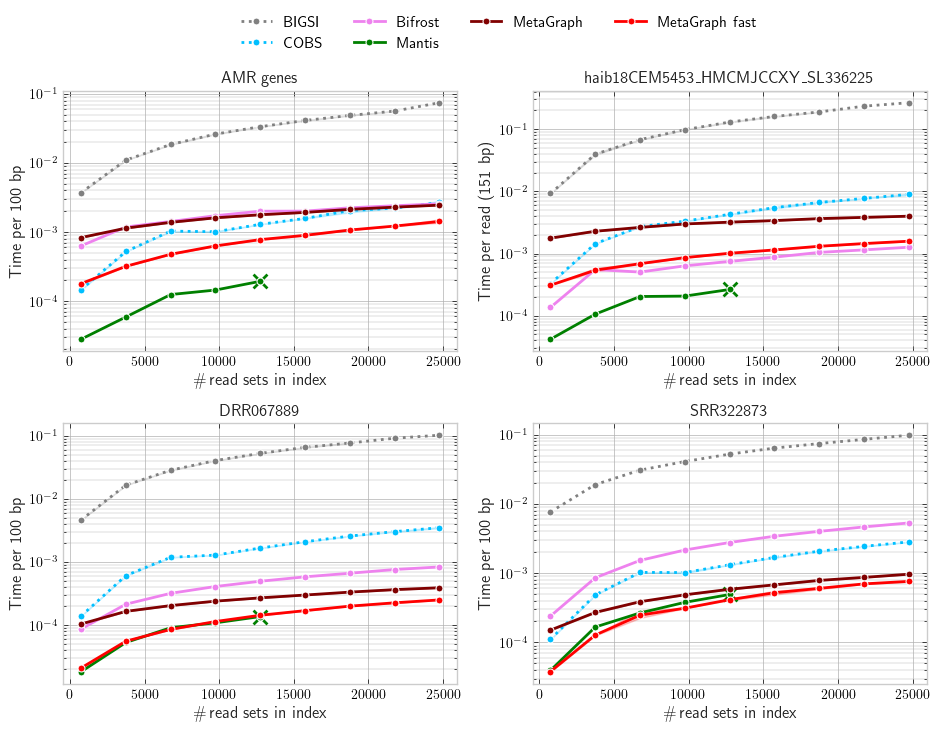

In [60]:
import re
import seaborn as sns

colors = {'BIGSI': 'grey',
          'Mantis': 'g',
          'Bifrost': 'violet',
          'COBS 1\%': 'royalblue',
          'COBS': 'deepskyblue',
          'MetaGraph-Align': 'black',
          'MetaGraph-LA': 'goldenrod',
          'MetaGraph-align-sparse-indexed': 'maroon',
          'MetaGraph': 'maroon',
          'MetaGraph (row-major), small': 'maroon'}

markers = {'COBS 1\%': 'o',
           'COBS': 'o',
           'MetaGraph (Rainbowfish)': '*',
           'MetaGraph (MultiBRWT)': 'x',
           'MetaGraph (Rainbow-BRWT)': '<',
           'MetaGraph': 'o',
           'MetaGraph OLD': 'x',
           'MetaGraph (row-major)': '^',
           'MetaGraph (row-major), small': '^',
           'MetaGraph small': 'o',
           'MetaGraph-align OLD': 'x',
#            'MetaGraph-Align': '*',
#            'MetaGraph-LA': '*',
           }

width = 3.487 * 1.3 * 2.1
height = width / 1.4 #/ 1.618

with matplotlib.style.context('seaborn-whitegrid'):
    fig, axes = plt.subplots(2, 2, figsize=(width, height))

def plot_query_time(i, j, DIR, OTHER, title=None, normalizer=1, y_label='Query time, sec'):
    ax = axes[i, j]

    results = {}
    results['BIGSI'] = parse_time_from_logs(glob.glob(OTHER + '/bigsi/*.err'))
#    results['COBS 1\%'] = parse_time_from_logs(glob.glob(OTHER + '/cobs_index_h7_fpr1/*.err'))
    results['COBS'] = parse_time_from_logs(glob.glob(OTHER + '/cobs_index_h4_fpr5/*.err'))
    results['Bifrost'] = parse_time_from_logs(glob.glob(OTHER + '/bifrost/*.err'))
    results['Mantis'] = parse_time_from_logs(glob.glob(OTHER + '/mantis.mst/*.out'))
    results['Mantis'].loc[results['Mantis']['n_samples'] > 14000] = np.nan
#    results['MetaGraph (Rainbowfish)'] = parse_time_from_logs(glob.glob(DIR + '/release_metagraph.primary.rbfish/*.err'))
#    results['MetaGraph (MultiBRWT)'] = parse_time_from_logs(glob.glob(DIR + '/release_metagraph.primary.brwt_relaxed/*.err'))
#    results['MetaGraph (Rainbow-BRWT)'] = parse_time_from_logs(glob.glob(DIR + '/release_metagraph.primary.rb_brwt/*.err'))
#    results['MetaGraph (row-major)'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.rd_sparse/*.err'))
    results['MetaGraph'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.small.rd_brwt/*.err'))
    results['MetaGraph fast'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.rd_brwt/*.err'))
#    results['MetaGraph fast Sparse'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.rd_sparse/*.err'))
#    results['MetaGraph OLD'] = parse_time_from_logs(glob.glob(DIR + '/release_metagraph.primary.rd_brwt/*.err'))
#    results['MetaGraph (RowDiff-MultiBRWT), no batch'] = parse_time_from_logs(glob.glob(DIR + '/release_metagraph.primary.rd_brwt.nobatch/*.err'))
#    results['MetaGraph-align OLD'] = parse_time_from_logs(glob.glob(DIR + '/release_metagraph.primary.rd_brwt.align/*.err'))
#    results['MetaGraph-align small'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.small.rd_brwt.align/*.err'))
#    results['MetaGraph-align'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.rd_brwt.align/*.err'))
#    results['MetaGraph-align-sparse'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.rd_sparse.align/*.err'))
#    results['MetaGraph-Align'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.rd_brwt.align_indexed/*.err'))
#    results['MetaGraph-LA'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.rd_brwt.align_labeled_indexed/*.err'))
#    results['Metagraph (no batch)'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.rb_brwt.notbatch/*.err'))

    # colors = ['c', 'b', 'g', 'r']

    for name, table in results.items():
        table.sort_values('n_samples', inplace=True)
#         x = table['n_samples']
#         y = table['total_time']
        table['total_time'] /= normalizer
#        x = results.index[~results[col].isna()]
#        y = results[col][~results[col].isna()]
        color = colors[name] if name in colors.keys() else 'red'
        m = markers[name] if name in markers.keys() else 'o'
        alpha = 1 #0.5 if name.startswith('MetaGraph (R') else 1
        sns.lineplot(ax=ax, x='n_samples', y='total_time', data=table, marker=m, ms=5, linewidth=2, label=name, color=color, alpha=alpha)
        if name.startswith('BIGSI') or name.startswith('COBS'):
            ax.lines[-1].set_linestyle(':')
        if name.endswith('no batch'):
            ax.lines[-1].set_linestyle('-.')
#        ax.plot(x, y, marker='o', ms=3, linewidth=2.5, label=name)

    n_s = results['Mantis']['n_samples'].max()
    ax.scatter(x=[n_s,], y=[results['Mantis']['total_time'][results['Mantis']['n_samples'] == n_s].mean()],
                marker='x', s=100, color='g', linewidth=2)

    if not title:
        title = DIR.split('.')[0].split('/')[-1].replace('_', '\_')
    ax.set_title(title)
    ax.set_xlabel('\#\,read sets in index')
    ax.set_ylabel(y_label)
    ax.set_yscale('log')
#    ax.set_xscale('log')
    ax.tick_params(reset=True, direction='in', which='both', bottom=True, top=True, left=True, right=True, width=0.5)
    ax.grid(True, linewidth=0.5)
    ax.grid(True, which='minor', linewidth=0.3, alpha=1)
#    ax.set_yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
#    ax.set_yticklabels(['10 µs', '100 µs', '1 ms', '10 ms', '100 ms'])

    ax.get_legend().remove()
#     legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4),
#                        ncol=3, fancybox=True, shadow=None, fontsize=10)
#     legend = ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)
#     legend = ax.legend(loc='best', fontsize=10, ncol=4, handleheight=2.4, labelspacing=0.05)

#     plt.tight_layout()
#     plt.savefig('query_time_user_time_{}_all_supp.pdf'.format(OTHER.split('/')[-1]), format='pdf', bbox_inches='tight')
#     plt.show()

#with matplotlib.style.context('seaborn-whitegrid'):
plot_query_time(0, 0, '/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/query_results/nucleotide_fasta_protein_homolog_model.fasta',
                '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/results/nucleotide_fasta_protein_homolog_model',
                title='AMR genes',
                normalizer=2135023 / 100, y_label='Time per 100 bp')
plot_query_time(0, 1, '/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/query_results/haib18CEM5453_HMCMJCCXY_SL336225.fasta',
                '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/results/haib18CEM5453_HMCMJCCXY_SL336225',
                normalizer=46400 / 2, y_label='Time per read (151 bp)')
plot_query_time(1, 0, '/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/query_results/DRR067889.fasta',
                '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/results/DRR067889',
                normalizer=5263530 / 100, y_label='Time per 100 bp')
plot_query_time(1, 1, '/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/query_results/SRR322873.fastq.gz',
                '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/results/SRR322873',
                normalizer=878515 / 100, y_label='Time per 100 bp')

# dummy handle for an empty legend entry
# l = plt.plot([0], [0], color='w')

handles, labels = axes[0, 0].get_legend_handles_labels()
# handles = [handles[0], l[0]] + handles[1:]
# labels = [labels[0], ''] + labels[1:]
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.53, 1.08),
           ncol=4, fancybox=True, shadow=None, fontsize=11, frameon=False)

plt.tight_layout()
plt.savefig('query_time_user_time_all_supp.pdf', format='pdf', bbox_inches='tight')
plt.show()

#### Manuscript

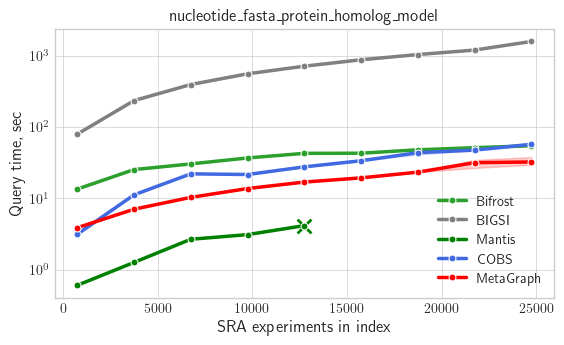

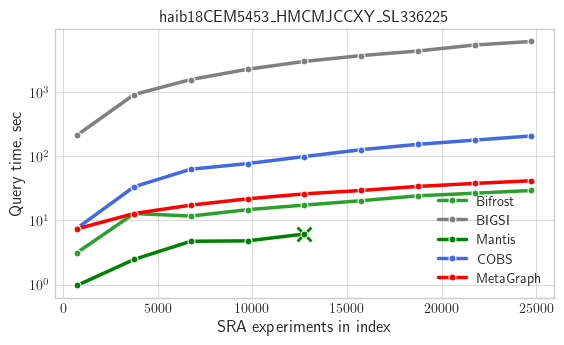

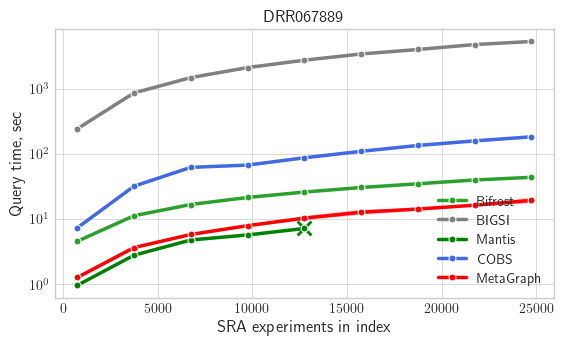

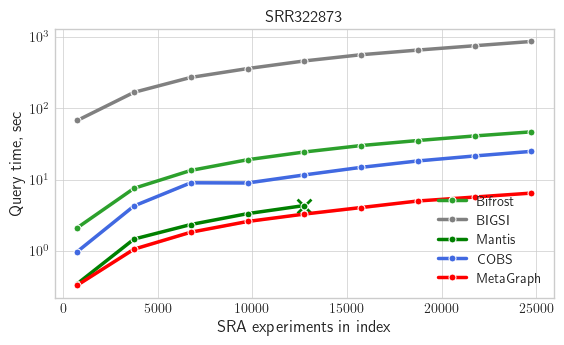

In [82]:
import re
import seaborn as sns
import matplotlib

colors = {'BIGSI': 'grey',
          'Mantis': 'g',
          'COBS': 'royalblue',
          'MetaGraph (RBFish)': 'blue',
          'MetaGraph (MultiBRWT)': 'maroon',
          'MetaGraph (RbBRWT)': 'orange',
          'MetaGraph': 'red',
          'MetaGraph NEW': 'red',
          'MetaGraph (small)': 'red',
          'MetaGraph (no batch)': 'red',
          'MetaGraph align': 'red'}

def plot_query_time(DIR, OTHER):
    results = {}
    results['Bifrost'] = parse_time_from_logs(glob.glob(OTHER + '/bifrost/*.err'))
    results['BIGSI'] = parse_time_from_logs(glob.glob(OTHER + '/bigsi/*.err'))
    results['Mantis'] = parse_time_from_logs(glob.glob(OTHER + '/mantis.mst/*.out'))
    results['Mantis'].loc[results['Mantis']['n_samples'] > 14000] = np.nan
    results['COBS'] = parse_time_from_logs(glob.glob(OTHER + '/cobs_index_h4_fpr5/*.err'))
    results['MetaGraph'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.primary.rd_brwt/*.err'))
#     results['MetaGraph NEW'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.primary.rd_brwt_rd2/*.err'))

    width = 3.487 * 1.5 * 1.1
    height = width / 1.618

    fig, axes = plt.subplots(1, 1, figsize=(width, height))
    ax = axes

    # colors = ['c', 'b', 'g', 'r']

    for name, table in results.items():
        table.sort_values('n_samples', inplace=True)
        x = table['n_samples']
        y = table['total_time']
#        x = results.index[~results[col].isna()]
#        y = results[col][~results[col].isna()]
        color = colors[name] if name in colors.keys() else None
        sns.lineplot(ax=ax, x='n_samples', y='total_time', data=table, marker='o', ms=5, linewidth=2.5, label=name, color=color)
        if name == 'MetaGraph (no batch)':
            ax.lines[-1].set_linestyle('-.')
#         if name == 'MetaGraph':
#             ax.lines[-1].set_linestyle('-.')
        if name == 'MetaGraph align':
            ax.lines[-1].set_linestyle(':')
#        ax.plot(x, y, marker='o', ms=3, linewidth=2.5, label=name)

    n_s = results['Mantis']['n_samples'].max()
    plt.scatter(x=[n_s,], y=[results['Mantis']['total_time'][results['Mantis']['n_samples'] == n_s].mean()], marker='x', s=100, color='g', linewidth=2)

    ax.set_title(DIR.split('.')[0].split('/')[-1].replace('_', '\_'))
    ax.set_xlabel('SRA experiments in index')
    ax.set_ylabel('Query time, sec')
    ax.set_yscale('log')
#    ax.set_xscale('log')
    ax.tick_params(reset=True, direction='in', which='both', bottom=True, top=True, left=True, right=True, width=0.5)
    ax.grid(True, linewidth=0.5)
#     if DIR.split('.')[0].split('/')[-1].startswith('DRR'):
#         ax.set_ylim([0.2, 10000])

    legend = ax.legend(loc="lower right", fontsize=10)

    plt.tight_layout()
    plt.savefig('query_time_user_time_{}_all.pdf'.format(OTHER.split('/')[-1]), format='pdf', bbox_inches='tight')
    plt.show()

with matplotlib.style.context('seaborn-whitegrid'):
    plot_query_time('/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/query_results/nucleotide_fasta_protein_homolog_model.fasta',
                    '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/results/nucleotide_fasta_protein_homolog_model')
    plot_query_time('/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/query_results/haib18CEM5453_HMCMJCCXY_SL336225.fasta',
                    '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/results/haib18CEM5453_HMCMJCCXY_SL336225')
    plot_query_time('/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/query_results/DRR067889.fasta',
                    '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/results/DRR067889')
    plot_query_time('/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/query_results/SRR322873.fastq.gz',
                    '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/results/SRR322873')

### Other plots

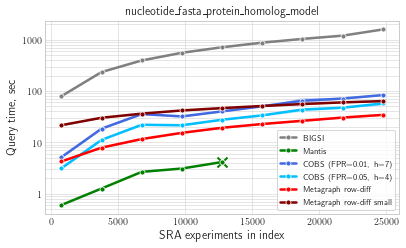

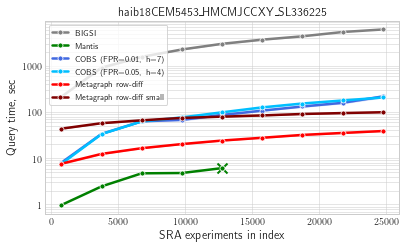

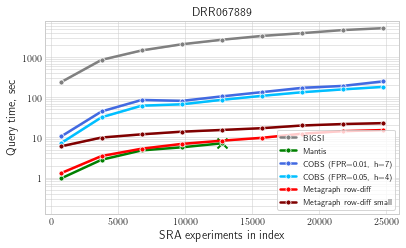

In [79]:
import re
import seaborn as sns
width = 3.487 * 1.5 * 1.1
height = width / 1.618 * 1.2

plt.rc('font', family='sans-serif')#, serif='Times')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=10)
#plt.rcParams['mathtext.fontset'] = 'stix'
#plt.rcParams['font.family'] = 'STIXGeneral'
params = {
'text.usetex': True,
#'font.size': 15,
#'text.latex.unicode': True
}
plt.rcParams.update(params)

import matplotlib

def parse_time_from_logs(log_files):
    table = pd.DataFrame(columns=['n_samples', 'total_time'])
    for log_file in log_files:
        try:
#             if log_file.split('/')[-2].startswith('metagraph'):
#                 lines_time = !grep "total time:" $log_file
#                 for line_time in lines_time:
#                     query_time = float(re.search('total time: ([0-9\.]*)', line_time).group(1))
#                     table = table.append([{'n_samples': int(log_file.split('/')[-1].split('.')[-2]),
#                                            'total_time': query_time}])
#                 continue

            if log_file.split('/')[-2].startswith('mantis'):
                lines_time = !grep "Time =" $log_file
                for line_time in lines_time:
                    try:
                        query_time = float(re.search('Time = ([0-9\.]*) s', line_time).group(1))
                        table = table.append([{'n_samples': int(log_file.split('/')[-1].split('.')[-2]),
                                               'total_time': query_time}])
                    except:
                        query_time = float(re.search('Time = ([0-9\.]*) ms', line_time).group(1)) / 1000
                        table = table.append([{'n_samples': int(log_file.split('/')[-1].split('.')[-2]),
                                               'total_time': query_time}])                        
                continue

            lines_user = !grep "User time (seconds):" $log_file
            lines_system = !grep "System time (seconds):" $log_file
            assert(len(lines_user) == len(lines_system))
            for line_user, line_system in zip(lines_user, lines_system):
                query_time = float(re.search('User time \(seconds\): ([0-9\.]*)', line_user).group(1))
                #query_time += float(re.search('System time \(seconds\): ([0-9\.]*)', line_system).group(1))
                table = table.append([{'n_samples': int(log_file.split('/')[-1].split('.')[-2]),
                                       'total_time': query_time}])
        except:
            pass

    return table

colors = {'BIGSI': 'grey',
          'Mantis': 'g',
          'COBS (FPR={}, h={})'.format(1 / 100, 7): 'royalblue',
          'COBS (FPR={}, h={})'.format(5 / 100, 4): 'deepskyblue',
          'MetaGraph (RBFish)': 'blue',
          'MetaGraph (MultiBRWT)': 'maroon',
          'MetaGraph (RbBRWT)': 'orange',
          'MetaGraph': 'maroon',
          'MetaGraph (small)': 'red',
          'MetaGraph (no batch)': 'red',
          'MetaGraph Align': 'maroon',
          'Metagraph row-diff': 'red',
          'Metagraph row-diff small': 'maroon'}

def plot_query_time(DIR, OTHER, ylim_factor=(1, 1)):
    results = {}
    results['BIGSI'] = parse_time_from_logs(glob.glob(OTHER + '/bigsi/*.err'))
    results['Mantis'] = parse_time_from_logs(glob.glob(OTHER + '/mantis.mst/*.out'))
    results['Mantis'].loc[results['Mantis']['n_samples'] > 14000] = np.nan
    results['COBS (FPR={}, h={})'.format(1 / 100, 7)] = parse_time_from_logs(glob.glob(OTHER + '/cobs_index_h7_fpr1/*.err'))
    results['COBS (FPR={}, h={})'.format(5 / 100, 4)] = parse_time_from_logs(glob.glob(OTHER + '/cobs_index_h4_fpr5/*.err'))
    results['Metagraph row-diff'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.primary.rd_brwt/*.err'))
    results['Metagraph row-diff small'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.primary.small.rd_brwt/*.err'))

    width = 3.487 * 1.5 * 1.1
    height = width / 1.618

    fig, axes = plt.subplots(1, 1, figsize=(width, height))
    ax = axes

    # colors = ['c', 'b', 'g', 'r']

    for name, table in results.items():
        table.sort_values('n_samples', inplace=True)
        x = table['n_samples']
        y = table['total_time']
#        x = results.index[~results[col].isna()]
#        y = results[col][~results[col].isna()]
        color = colors[name] if name in colors.keys() else None
        sns.lineplot(ax=ax, x='n_samples', y='total_time', data=table, marker='o', ms=5, linewidth=2.5, label=name, color=color)
        if name == 'MetaGraph (no batch)':
            ax.lines[-1].set_linestyle('-.')
        if name == 'MetaGraph (small)':
            ax.lines[-1].set_linestyle('-.')
        if name == 'MetaGraph Align':
            ax.lines[-1].set_linestyle(':')
#        ax.plot(x, y, marker='o', ms=3, linewidth=2.5, label=name)

    n_s = results['Mantis']['n_samples'].max()
    plt.scatter(x=[n_s,], y=[results['Mantis']['total_time'][results['Mantis']['n_samples'] == n_s].mean()], marker='x', s=100, color='g', linewidth=2)

    ax.set_title(DIR.split('.')[0].split('/')[-1].replace('_', '\_'))
    ax.set_xlabel('SRA experiments in index')
    ax.set_ylabel('Query time, sec')
    ax.set_yscale('log')
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_ylim([ax.get_ylim()[0] * ylim_factor[0], ax.get_ylim()[1] * ylim_factor[1]])
    ax.tick_params(reset=True, direction='in', which='both', bottom=True, top=True, left=True, right=True, width=0.5)
    ax.grid(True, linewidth=0.5, which="both")

    legend = ax.legend(loc="best", fontsize=8, frameon=True)
#    legend.get_frame().set_facecolor('none')

    plt.tight_layout()
    plt.savefig('query_time_{}_slides.pdf'.format(OTHER.split('/')[-1]), format='pdf', bbox_inches='tight')
    plt.show()

with matplotlib.style.context('seaborn-whitegrid'):
    plot_query_time('/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/query_results/nucleotide_fasta_protein_homolog_model.fasta',
                    '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/results/nucleotide_fasta_protein_homolog_model')
    plot_query_time('/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/query_results/haib18CEM5453_HMCMJCCXY_SL336225.fasta',
                    '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/results/haib18CEM5453_HMCMJCCXY_SL336225')
    plot_query_time('/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/query_results/DRR067889.fasta',
                    '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/results/DRR067889',
                    ylim_factor=(0.2, 1))